In [1]:
import os
import sys
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pickle
from tensorflow import keras 
warnings.filterwarnings("ignore")
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

In [2]:
sys.path.append(os.path.join(os.path.dirname(os.path.dirname(os.getcwd())),'python-packages/'))
from deep_hashing_models import *
from similarities import *
from lsh_search import *

# 1. Data Preparation (Shingling)

In [3]:
data_repo = os.path.join(os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd()))),'data/')
df_distinct_stacks = pd.read_csv(data_repo + 'frequent_stack_traces.csv', index_col = [0])
df_measures = pd.read_csv(data_repo + 'similarity-measures-pairs.csv', index_col = [0])
n_stacks = df_distinct_stacks.shape[0]
n_stacks

1000

In [4]:
vectorizer_bag_of_frames = CountVectorizer(token_pattern = r"(?u)\b[a-zA-Z0-9_.]{2,}\b")
s = df_distinct_stacks['stackTraceCusto'].apply(lambda x : x.replace('\n',' '))
s = s.apply(lambda x : x.replace('$',''))
s = s.apply(lambda x : x.replace('/',''))
s = s.apply(lambda x : x.replace('<',''))
s = s.apply(lambda x : x.replace('>',''))
X_bag_of_frames = vectorizer_bag_of_frames.fit_transform(list(s)).toarray()
df_bag_of_frames = pd.DataFrame(data = X_bag_of_frames, columns = vectorizer_bag_of_frames.get_feature_names())
df_bag_of_frames.shape

(1000, 2244)

In [5]:
df_bag_of_frames

,aiguillageetiquette_raffin.getimprimantedest,aiguillageetiquettecasier.findimpr,aiguillageetiquettecasier.getimprimantedest,avrilfnspenbembal.closecurrentpalette,avrilfnspenbembal.quitprepprep,com.mycompany.achats.edi.modele.regleenvoicde__jvst5b2_1a6a.getrenvoimodif,com.mycompany.achats.services.commande.impl.commandeserviceimpl.load,com.mycompany.achats.services.commande.impl.commandeserviceimplenhancerbycglib69294e2f.cglibload047,com.mycompany.achats.services.commande.impl.commandeserviceimplenhancerbycglib69294e2f.cglibload048,com.mycompany.achats.services.commande.impl.commandeserviceimplenhancerbycglib69294e2f.load,...,sun.reflect.generatedmethodaccessor5281.invoke,sun.reflect.generatedmethodaccessor575096.invoke,sun.reflect.generatedmethodaccessor6410.invoke,sun.reflect.generatedmethodaccessor80608.invoke,sun.reflect.generatedmethodaccessor80619.invoke,sun.reflect.generatedmethodaccessor844599.invoke,sun.reflect.generatedmethodaccessor853912.invoke,sun.reflect.generatedmethodaccessor93404.invoke,sun.reflect.nativemethodaccessorimpl.invoke,sun.reflect.nativemethodaccessorimpl.invoke0
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# 2. MinHash

In [6]:
nb_permutations = 64
size_vector = 16
embeddings = min_hash (nb_permutations, size_vector, df_bag_of_frames)

# 3. Locality Sensitive Hashing

In [7]:
params = lsh_hyperparams(nb_permutations)
'(K,L)'
params 

[(1, 64), (2, 32), (4, 16), (8, 8), (16, 4), (32, 2), (64, 1)]

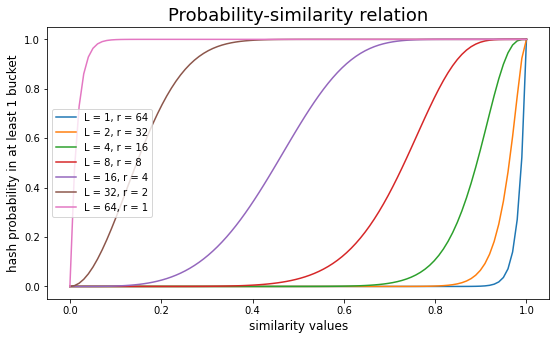

In [8]:
plt.rcParams["figure.figsize"] = [9, 5]
x = np.linspace(0, 1, 100)
for param in params:
    y = 1 - (1 - (x)**param[1])**param[0]
    plt.plot(x, y, label = 'L = %d, r = %d' %param)
plt.xlabel("similarity values", fontsize = 12)
plt.ylabel("hash probability in at least 1 bucket", fontsize = 12)
plt.title('Probability-similarity relation', fontsize = 18)
plt.legend()

In [9]:
df_probLSH = mean_prob_hashing_smallest_elt(n_stacks, params, embeddings, size_vector, df_measures, 'Jaccard', trace = False)

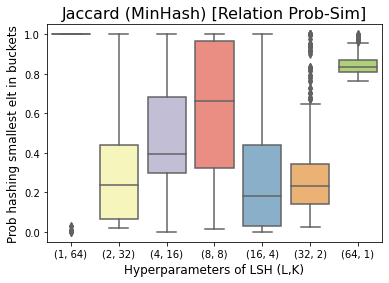

In [10]:
f, ax = plt.subplots(figsize=(6, 4))
ax = sns.boxplot(data = df_probLSH, palette="Set3")
plt.xlabel("Hyperparameters of LSH (L,K)", fontsize = 12)
plt.ylabel("Prob hashing smallest elt in buckets", fontsize = 12)
plt.title('Jaccard (MinHash) [Relation Prob-Sim]', fontsize = 16)
plt.savefig('Results/MinHash/Jaccard-Relation-Prob-Sim', bbox_inches='tight')
plt.show()

In [11]:
'L = K = 8'
L, K = params[3]
L, K

(8, 8)

In [12]:
hash_tables = create_hash_tables(L, K, size_vector, embeddings)

In [13]:
'pointer to the stack trace'
index = random.randint(0,n_stacks)
index = 866

In [14]:
set_near_duplicates = near_duplicates(L, K, size_vector, 866, embeddings, hash_tables)
set_near_duplicates

{587, 675, 866}

In [15]:
list_near_duplicate_pairs = near_duplicate_pairs(index, set_near_duplicates, n_stacks)
n_duplicate_pairs = len(list_near_duplicate_pairs)

In [16]:
near_duplicates_sim = df_measures['Jaccard'][list_near_duplicate_pairs].sort_values(ascending = False)
near_duplicates_sim

447040    0.954545
414700    0.869565
Name: Jaccard, dtype: float64

In [17]:
set_real_nns, real_nns_sim = real_nns(index, df_measures, 'Jaccard', n_stacks, n_duplicate_pairs)
set_real_nns

{587, 675}

In [18]:
real_nns_sim[:n_duplicate_pairs]

447040    0.954545
414700    0.869565
dtype: float64

# 4. Metrics (MinHash)

## 4.1. Ratio of finding the $k$ real nearest neighbor with the Least $L$ (Recal rate at $k$ first positions)

In [19]:
'All params'
k_first_positions = 1
recal_rate(n_stacks, params, embeddings, size_vector, df_measures, k_first_positions, 'Jaccard')

0.903

In [ ]:
'Best param'
k_first_positions = 1
recal_rate_one_param(n_stacks, params[3], embeddings, size_vector, df_measures, k_first_positions, 'Jaccard')

-----------------------------------------------------------------

In [20]:
'All params'
k_first_positions = 3
recal_rate(n_stacks, params, embeddings, size_vector, df_measures, k_first_positions, 'Jaccard')

0.9223333333333318

In [ ]:
'Best param'
k_first_positions = 3
recal_rate_one_param(n_stacks, params[3], embeddings, size_vector, df_measures, k_first_positions, 'Jaccard')

-----------------------------------------------------------------

In [21]:
'All params'
k_first_positions = 5
recal_rate(n_stacks, params, embeddings, size_vector, df_measures, k_first_positions, 'Jaccard')

0.9231999999999994

In [ ]:
'Best param'
k_first_positions = 5
recal_rate_one_param(n_stacks, params[3], embeddings, size_vector, df_measures, k_first_positions, 'Jaccard')

## 4.2. Generalized MRR

In [22]:
df_knns = mean_generalized_mrr(n_stacks, params, embeddings, size_vector, df_measures ,'Jaccard', trace = False)
df_knns.mean(skipna = True, axis = 0)

(1, 64)    1.000000
(2, 32)    0.992936
(4, 16)    0.951731
(8, 8)     0.951682
(16, 4)    0.858465
(32, 2)    0.926114
(64, 1)    0.999348
dtype: float64

In [23]:
df_knns.mean(skipna = True, axis = 0).mean()

0.9543251818596197

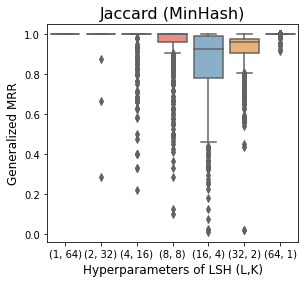

In [24]:
f, ax = plt.subplots(figsize=(4.5, 4))
ax = sns.boxplot(data = df_knns, palette="Set3")
plt.xlabel("Hyperparameters of LSH (L,K)", fontsize = 12)
plt.ylabel("Generalized MRR", fontsize = 12)
plt.title('Jaccard (MinHash)', fontsize = 16)
plt.savefig('Results/MinHash/Generalized-MRR', bbox_inches='tight')
plt.show()

## 4.3. Recall w.r.t. LSH

In [19]:
df_recall = recall_all(n_stacks, params, embeddings, size_vector, df_measures ,'Jaccard', trace = True)
df_recall.mean(skipna = True)

(1, 64)
0
100
200
300
400
500
600
700
800
900
-----------------------------
(2, 32)
0
100
200
300
400
500
600
700
800
900
-----------------------------
(4, 16)
0
100
200
300
400
500
600
700
800
900
-----------------------------
(8, 8)
0
100
200
300
400
500
600
700
800
900
-----------------------------
(16, 4)
0
100
200
300
400
500
600
700
800
900
-----------------------------
(32, 2)
0
100
200
300
400
500
600
700
800
900
-----------------------------
(64, 1)
0
100
200
300
400
500
600
700
800
900
-----------------------------


(1, 64)    1.000000
(2, 32)    1.000000
(4, 16)    0.654683
(8, 8)     0.825126
(16, 4)    0.796194
(32, 2)    0.803715
(64, 1)    0.974904
dtype: float64

In [26]:
df_recall.mean(skipna = True, axis = 0).mean()

0.887905832229017

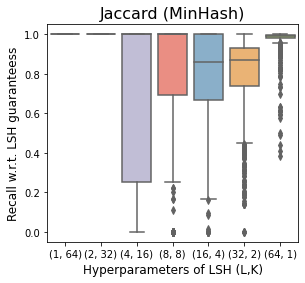

In [20]:
f, ax = plt.subplots(figsize=(4.5, 4))
ax = sns.boxplot(data = df_recall, palette="Set3")
plt.xlabel("Hyperparameters of LSH (L,K)", fontsize = 12)
plt.ylabel("Recall w.r.t. LSH guaranteess", fontsize = 12)
plt.title('Jaccard (MinHash)', fontsize = 16)
plt.savefig('Results/MinHash/Recall-LSH', bbox_inches='tight')
plt.show()

## 4.4. Precision w.r.t. LSH

In [21]:
df_precision = precision_all(n_stacks, params, embeddings, size_vector, df_measures ,'Jaccard', trace = True)
df_precision.mean(skipna = True, axis = 0)

(1, 64)
0
100
200
300
400
500
600
700
800
900
-----------------------------
(2, 32)
0
100
200
300
400
500
600
700
800
900
-----------------------------
(4, 16)
0
100
200
300
400
500
600
700
800
900
-----------------------------
(8, 8)
0
100
200
300
400
500
600
700
800
900
-----------------------------
(16, 4)
0
100
200
300
400
500
600
700
800
900
-----------------------------
(32, 2)
0
100
200
300
400
500
600
700
800
900
-----------------------------
(64, 1)
0
100
200
300
400
500
600
700
800
900
-----------------------------


(1, 64)    0.836364
(2, 32)    0.265823
(4, 16)    0.470020
(8, 8)     0.806101
(16, 4)    0.635814
(32, 2)    0.762312
(64, 1)    1.000000
dtype: float64

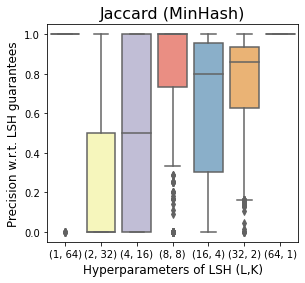

In [22]:
f, ax = plt.subplots(figsize=(4.5, 4))
ax = sns.boxplot(data = df_precision, palette="Set3")
plt.xlabel("Hyperparameters of LSH (L,K)", fontsize = 12)
plt.ylabel("Precision w.r.t. LSH guarantees", fontsize = 12)
plt.title('Jaccard (MinHash)', fontsize = 16)
plt.savefig('Results/MinHash/precision-LSH', bbox_inches='tight')
plt.show()

## 4.5. Fscore w.r.t. LSH

In [23]:
df_score_all = fscore_all(df_precision, df_recall)
df_score_all.mean(skipna = True)

(1, 64)    0.836364
(2, 32)    0.274262
(4, 16)    0.396739
(8, 8)     0.750172
(16, 4)    0.633331
(32, 2)    0.747800
(64, 1)    0.986050
dtype: float64

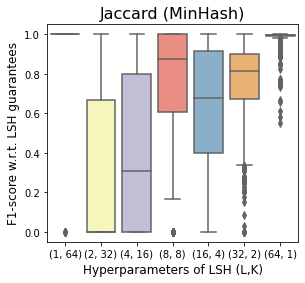

In [24]:
f, ax = plt.subplots(figsize=(4.5, 4))
ax = sns.boxplot(data = df_score_all, palette="Set3")
plt.xlabel("Hyperparameters of LSH (L,K)", fontsize = 12)
plt.ylabel("F1-score w.r.t. LSH guarantees", fontsize = 12)
plt.title('Jaccard (MinHash)', fontsize = 16)
plt.savefig('Results/MinHash/fscore-LSH', bbox_inches='tight')
plt.show()